# Home Office procurement card spend over £500: 2020

There was a [tweet on 26th March 2020](https://twitter.com/lloydhardy/status/1375363511962980352?s=20) with a screenshot of some Home Office spending. I just got curious about how easy it would be to harvest, clean and summarise the spending data.

* Data [downloaded from here](https://www.gov.uk/government/publications/home-office-procurement-card-spend-over-500-2020) on 26-Mar-2021
* Data covers the 2020 calendar year
* Data published 19-Mar-2021

[Jump to the section with 2020 spending reprt](#Spending-2020) - suppliers where most money was spent.
* Total spend
* Spending per month
* Top 20 suppliers

`cleaned_agg_spend.csv` contains data aggregated by supplier for 2020. Columns:

* Supplier
* total_spent_supplier - total spent with supplier over year
* percent_share_spend - percentage of total spend with supplier 
* number_purchases - number of purchases made with supplier
* first_purchase - data first purchase made from supplier (yyyy-mm-dd)
* last_purchase - date last purchase made from supplier (yyyy-mm-dd)

`cleaned_spend.csv` contains the merged data from all year 2020 CSV files.


In [1]:
%matplotlib inline

import re

from bs4 import BeautifulSoup
import requests

from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Get Data from Online CSVs

In [2]:
req = requests.get('https://www.gov.uk/government/publications/home-office-procurement-card-spend-over-500-2020')
assert req.status_code == 200

parser = BeautifulSoup(req.content, 'html.parser')

# Filter out hrefs that are CSV preview.
csv_match = lambda href: href and re.compile('csv$').search(href)

hrefs = parser.find_all(href=csv_match)

In [3]:
# Some columns contain extra characters so don't rely on the provided names.
df_generator = (
    pd.read_csv(
        href['href'],
        usecols=[0, 1, 2],
        names=['Date', 'Amount', 'Supplier'], 
        dtype={'Amount': np.float64, 'Supplier': object},
        thousands=',',
        header=0, 
        parse_dates=[0], 
        dayfirst=True
    ) for href in hrefs
)
spend = pd.concat(df_generator, ignore_index=True)

## Clean

The supplier names aren't always consistent. All of the space characters could've been removed, but this is more readable.

In [4]:
spend['Supplier'] = spend['Supplier'].str.strip()
spend['Supplier'] = spend['Supplier'].replace('\s+', ' ', regex=True)
spend['Supplier'] = spend['Supplier'].str.upper()
spend['Supplier'] = spend['Supplier'].replace('A1-ENVIRO SCIENCES.', 'A1 ENVIRO SCIENCE', regex=False)
spend['Supplier'] = spend['Supplier'].replace('ADDISONLEE', 'ADDISON LEE', regex=False)
spend['Supplier'] = spend['Supplier'].replace('ADOBE CREATIVE CLOUD', 'ADOBE', regex=False)
spend['Supplier'] = spend['Supplier'].replace('CREATIVE CLOUD INDIV', 'ADOBE', regex=False)
spend['Supplier'] = spend['Supplier'].replace('ANDARK PRMTS LTD', 'ANDARK', regex=False)
spend['Supplier'] = spend['Supplier'].replace('ANDARK PROMOTIONS', 'ANDARK', regex=False)
spend['Supplier'] = spend['Supplier'].replace('ARGOS LTD', 'ARGOS', regex=False)
spend['Supplier'] = spend['Supplier'].replace('BACKCARE SOLUTIONS LTD', 'BACKCARE SOLUTIONS', regex=False)
spend['Supplier'] = spend['Supplier'].replace('BARDEN UK LTD', 'BARDEN UK', regex=False)
spend['Supplier'] = spend['Supplier'].replace('BRISTOL MANAGEMENT CEN', 'BRISTOL MANAGEMENT', regex=False)
spend['Supplier'] = spend['Supplier'].replace('CURRYS ONLINE', 'CURRYS', regex=False)
spend['Supplier'] = spend['Supplier'].replace('FURNITURE@WORK LIMITED', 'FURNITUREATWORK', regex=False)
spend['Supplier'] = spend['Supplier'].replace('GLOVECLUB', 'GLOVE CLUB LTD', regex=False)
spend['Supplier'] = spend['Supplier'].replace('IKEA LTD SHOP ONLINE', 'IKEA', regex=False)
spend['Supplier'] = spend['Supplier'].replace('IKEA LTD 262 LAKESIDE', 'IKEA', regex=False)
spend['Supplier'] = spend['Supplier'].replace('iZ NEBULA CREATIVE', 'iZ NEBULA CREATIVE LIMITED', regex=False)
spend['Supplier'] = spend['Supplier'].replace('KEYMT INSTALLATION LTD', 'KEY MANAGEMENT INSTALLATION LTD', regex=False)
spend['Supplier'] = spend['Supplier'].replace('MARINESUPERSTORE', 'MARINE SUPER STORE LTD', regex=False)
spend['Supplier'] = spend['Supplier'].replace('MERSEYTRAVEL', 'MERSEY TRAVEL', regex=False)
spend['Supplier'] = spend['Supplier'].replace('MONSTERPETSUPPLIES', 'MONSTER PET SUPPLIES', regex=False)
spend['Supplier'] = spend['Supplier'].replace('NBBMATTING', 'NBB MATTING', regex=False)
spend['Supplier'] = spend['Supplier'].replace('NEPTUN QTU TIRANE', 'NEPTUN QTU', regex=False)
spend['Supplier'] = spend['Supplier'].replace('PARLI-TRAINING', 'PARLI TRAINING', regex=False)
spend['Supplier'] = spend['Supplier'].replace('R.H. & K.M.P. SVS', 'R.H. & K.M.P. SERVICES', regex=False)
spend['Supplier'] = spend['Supplier'].replace('SIMPLY ERGONOMIC L', 'SIMPLY ERGONOMIC LTD', regex=False)
spend['Supplier'] = spend['Supplier'].replace('SLIDO', 'SLI DO', regex=False)
spend['Supplier'] = spend['Supplier'].replace('SP BEAUTIFULB ROWS', 'SP BEAUTIFUL BROWS', regex=False)
spend['Supplier'] = spend['Supplier'].replace('TRUE GRIP OFF ROAD LTD', 'TRUE GRIP ATV LTD', regex=False)




## Spending 2020

In [5]:
total_spend = spend['Amount'].sum()
md(f'### Total spent: £{round(total_spend, 2):,}')

### Total spent: £2,097,376.09

### Spending per Month

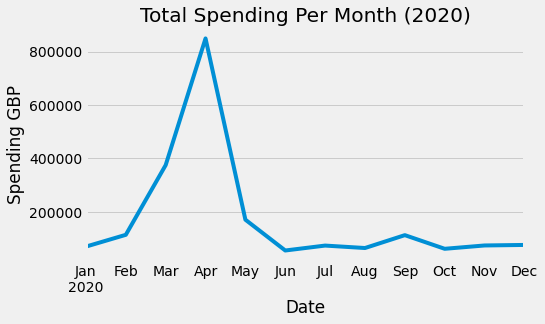

In [6]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(7,4))
plt.ylabel('Spending GBP')
plt.title('Total Spending Per Month (2020)')
spend.set_index('Date').resample('M').sum().plot(y='Amount', ax=ax, legend=False)
plt.show()

### Top 20 Spending

In [7]:
grouped = spend.groupby('Supplier')

report = grouped.agg(
    total_spent_supplier=pd.NamedAgg(column='Amount', aggfunc='sum'),
    percent_share_spend=pd.NamedAgg(
        column='Amount',
        aggfunc=lambda x: round(np.sum(x) / total_spend * 100, 3)
    ),
    number_purchases=pd.NamedAgg(column='Amount', aggfunc='size'),
    first_purchase=pd.NamedAgg(column='Date', aggfunc='min'),
    last_purchase=pd.NamedAgg(column='Date', aggfunc='max')
)
report.sort_values('total_spent_supplier', ascending=False).head(20)

,total_spent_supplier,percent_share_spend,number_purchases,first_purchase,last_purchase
Supplier,,,,,
GLOVE CLUB LTD,649316.99,30.959,42,2020-02-17,2020-09-25
ROBERT PEEL INTERNATIONAL,216000.00,10.299,1,2020-04-23,2020-04-23
ARDEN WINCH & COMPANY,92199.06,4.396,11,2020-03-02,2020-04-20
GLOBAL BEAUTY PRODUCTS,72656.64,3.464,5,2020-03-26,2020-04-08
TGS COACHWORKS,71506.51,3.409,5,2020-04-16,2020-05-15
AMAZON,68137.13,3.249,73,2020-01-08,2020-12-24
SP BEAUTIFUL BROWS,53158.48,2.535,7,2020-03-23,2020-04-22
SHARP & ENRIGHT,44773.36,2.135,30,2020-01-21,2020-10-19
THOMASKNEALE,30465.60,1.453,8,2020-09-09,2020-10-05


In [8]:
spend.to_csv('cleaned_spend.csv', index=False)
report.to_csv('cleaned_agg_spend.csv')